In [77]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser
from IPython.display import clear_output

In [78]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset'

In [79]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset/')

In [80]:
df = pd.read_csv("tesseract2.csv")

In [81]:
df.shape

(299, 37)

In [82]:
df.drop_duplicates(subset=["x", "y", "imageName"], keep="first", inplace=True)

In [83]:
df.shape

(195, 37)

In [84]:
df.describe()

,Unnamed: 0,left,top,width,height,conf,x,y,PageHeight,PageWidth,...,issue,invoice date,invoice dt,due date,payment due date,ack date,ack dt,contextPresent,contextDist,output
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.112821,1203.600000,1203.687179,198.343590,32.451282,82.320841,1401.943590,1236.138462,3482.369231,2576.343590,...,39.123246,474.848404,603.902233,59.124071,4.728661,28.254367,97.891474,0.610256,535.361837,0.323077
std,87.394517,735.950927,782.358165,89.033064,7.848530,20.195334,730.810341,782.563371,500.880644,328.723664,...,198.403934,754.822983,744.422758,276.612378,46.574005,219.319586,462.162178,0.488947,624.842203,0.468856
min,0.000000,75.000000,67.000000,98.000000,16.000000,0.000000,210.000000,97.000000,1566.000000,1134.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,77.500000,555.500000,607.500000,156.000000,27.500000,74.643830,783.500000,635.500000,3300.000000,2479.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,155.000000,1232.000000,959.000000,182.000000,32.000000,90.819194,1415.000000,985.000000,3500.000000,2481.000000,...,0.000000,0.000000,429.516007,0.000000,0.000000,0.000000,0.000000,1.000000,392.081624,0.000000
75%,231.000000,1871.000000,1558.500000,211.000000,37.000000,96.236962,2104.500000,1598.500000,3508.000000,2550.000000,...,0.000000,596.505151,805.206614,0.000000,0.000000,0.000000,0.000000,1.000000,758.571239,1.000000
max,298.000000,3130.000000,3395.000000,821.000000,71.000000,96.945030,3278.000000,3424.000000,5313.000000,3542.000000,...,1361.009184,3226.750998,3226.750998,2075.708313,466.000000,2156.320013,2875.171125,1.000000,2614.345999,1.000000


In [85]:
len(df["imageName"].unique())

72

In [86]:
df.head()

,Unnamed: 0,left,top,width,height,conf,text,x,y,PageHeight,...,invoice date,invoice dt,due date,payment due date,ack date,ack dt,imageName,contextPresent,contextDist,output
0,72,1713,256,203,28,96.087402,21-07-2022,1916,284,3504,...,688.104643,688.104643,0.0,0.0,0.000000,0.000000,1.jpeg,1,688.104643,1
2,206,1648,1936,214,31,79.921706,1-oct-22. to 31,1862,1967,3504,...,0.000000,1077.894707,0.0,0.0,2156.320013,2156.320013,2.jpeg,1,1077.894707,0
3,204,1648,1936,136,31,48.239994,1-oct-22.,1784,1967,3504,...,0.000000,1049.665185,0.0,0.0,2099.243673,2099.243673,2.jpeg,1,1049.665185,0
4,203,376,486,163,35,95.528168,22-sep-22,539,521,3504,...,0.000000,0.000000,0.0,0.0,273.029302,273.029302,2.jpeg,0,0.000000,0
6,51,2100,779,172,37,86.337227,1-mar-23,2272,816,3300,...,392.081624,392.081624,0.0,0.0,0.000000,0.000000,3.jpeg,1,392.081624,1


In [87]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y>Y:
            df["isBottom"][index]=1
        elif y<Y:
            df["isTop"][index]=1
    
    for imageName in df["imageName"].unique():
        M = max(df[df["imageName"]==imageName]["contextDist"].to_numpy())
        for index in df.index:
            if df["imageName"][index]==imageName:
                df["contextDist"][index]/=M
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]

    df["conf"]/=100

    neighbourFields = ["date", "dated", "invoice", "inv", "delivery", "order", "due", "payment", "tax", "bill", "receipt", "issue", "invoice date", "invoice dt", "due date", "payment due date", "ack date", "ack dt"]

    for col in neighbourFields:
        df[col]/=4000
    
    colsToDrop = ["Unnamed: 0", "left", "top", "width", "height", "text", "PageHeight", "PageWidth", "imageName"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [88]:
preProcess(df)

/tmp/ipykernel_19063/555105736.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_19063/555105736.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isTop"][index]=1
/tmp/ipykernel_19063/555105736.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_19063/555105736.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [89]:
df

,conf,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,...,issue,invoice date,invoice dt,due date,payment due date,ack date,ack dt,contextPresent,contextDist,output
0,0.960874,0.772892,0.081050,1,0,1,0,0.029577,0.029577,0.172026,...,0.0,0.172026,0.172026,0.0,0.0,0.000000,0.000000,1,1.000000,1
2,0.799217,0.751109,0.561358,0,1,1,0,0.077206,0.077206,0.269474,...,0.0,0.000000,0.269474,0.0,0.0,0.539080,0.539080,1,1.000000,0
3,0.482400,0.719645,0.561358,0,1,1,0,0.066412,0.066412,0.262416,...,0.0,0.000000,0.262416,0.0,0.0,0.524811,0.524811,1,0.973811,0
4,0.955282,0.217426,0.148687,1,0,0,1,0.065258,0.065258,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.068257,0.068257,0,0.000000,0
6,0.863372,0.890980,0.247273,1,0,1,0,0.073277,0.073277,0.098020,...,0.0,0.098020,0.098020,0.0,0.0,0.000000,0.000000,1,0.912845,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,0.960039,0.793062,0.077340,1,0,1,0,0.033840,0.033840,0.134183,...,0.0,0.169751,0.169751,0.0,0.0,0.000000,0.000000,1,1.000000,1
293,0.959007,0.909020,0.375455,1,0,1,0,0.000000,0.000000,0.388302,...,0.0,0.000000,0.388302,0.0,0.0,0.000000,0.000000,1,1.000000,1
295,0.962639,0.910448,0.160775,1,0,1,0,0.043250,0.043250,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,NaN,1
296,0.577509,0.740741,0.340358,1,0,1,0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,NaN,0


In [90]:
df.describe()

,conf,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,...,issue,invoice date,invoice dt,due date,payment due date,ack date,ack dt,contextPresent,contextDist,output
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,152.000000,195.000000
mean,0.823208,0.544255,0.356838,0.774359,0.225641,0.507692,0.492308,0.109253,0.105627,0.135229,...,0.009781,0.118712,0.150976,0.014781,0.001182,0.007064,0.024473,0.610256,0.628148,0.323077
std,0.201953,0.277128,0.219835,0.419080,0.419080,0.501228,0.501228,0.144511,0.138338,0.156721,...,0.049601,0.188706,0.186106,0.069153,0.011644,0.054830,0.115541,0.488947,0.416031,0.468856
min,0.000000,0.059795,0.019529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.746438,0.305414,0.181143,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221328,0.000000
50%,0.908192,0.503426,0.284848,1.000000,0.000000,1.000000,0.000000,0.071719,0.067767,0.098020,...,0.000000,0.000000,0.107379,0.000000,0.000000,0.000000,0.000000,1.000000,0.852437,0.000000
75%,0.962370,0.818442,0.474214,1.000000,0.000000,1.000000,1.000000,0.134113,0.133182,0.189643,...,0.000000,0.149126,0.201302,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,0.969450,0.941556,0.978286,1.000000,1.000000,1.000000,1.000000,0.777005,0.777005,0.653586,...,0.340252,0.806688,0.806688,0.518927,0.116500,0.539080,0.718793,1.000000,1.000000,1.000000


In [91]:
df.dropna(inplace=True)

In [92]:
df.corr()

,conf,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,...,issue,invoice date,invoice dt,due date,payment due date,ack date,ack dt,contextPresent,contextDist,output
conf,1.000000,0.063481,0.060870,0.024127,-0.024127,0.071100,-0.071100,-0.098216,-0.106023,-0.110851,...,-0.223445,-0.086614,-0.050755,-0.000861,-0.313345,-0.082900,-0.008345,-0.169639,-0.107210,0.038501
x,0.063481,1.000000,-0.154213,0.045463,-0.045463,0.906069,-0.906069,0.191910,0.212276,0.298918,...,0.128348,0.250203,0.272292,0.045005,-0.095744,0.039343,0.018049,0.471043,0.527061,0.301161
y,0.060870,-0.154213,1.000000,-0.858842,0.858842,-0.132283,0.132283,0.345528,0.360060,0.502985,...,0.155212,0.470668,0.509734,0.117732,-0.093148,0.131256,0.182582,-0.025787,0.051015,-0.503336
isTop,0.024127,0.045463,-0.858842,1.000000,-1.000000,0.042723,-0.042723,-0.382492,-0.385584,-0.605999,...,-0.138066,-0.541585,-0.623399,-0.170272,0.064323,-0.246131,-0.339924,-0.180759,-0.260500,0.336484
isBottom,-0.024127,-0.045463,0.858842,-1.000000,1.000000,-0.042723,0.042723,0.382492,0.385584,0.605999,...,0.138066,0.541585,0.623399,0.170272,-0.064323,0.246131,0.339924,0.180759,0.260500,-0.336484
isRight,0.071100,0.906069,-0.132283,0.042723,-0.042723,1.000000,-1.000000,0.207794,0.209020,0.241618,...,0.104508,0.242855,0.256153,-0.012311,-0.131802,0.061123,0.145232,0.343557,0.420800,0.268002
isLeft,-0.071100,-0.906069,0.132283,-0.042723,0.042723,-1.000000,1.000000,-0.207794,-0.209020,-0.241618,...,-0.104508,-0.242855,-0.256153,0.012311,0.131802,-0.061123,-0.145232,-0.343557,-0.420800,-0.268002
date,-0.098216,0.191910,0.345528,-0.382492,0.382492,0.207794,-0.207794,1.000000,0.989289,0.415531,...,0.094346,0.663241,0.587312,0.244552,-0.003611,-0.014479,0.559058,0.238845,0.275778,-0.164120
dated,-0.106023,0.212276,0.360060,-0.385584,0.385584,0.209020,-0.209020,0.989289,1.000000,0.420502,...,0.092887,0.651458,0.575812,0.266023,0.000038,-0.010383,0.498826,0.234324,0.290577,-0.166781
invoice,-0.110851,0.298918,0.502985,-0.605999,0.605999,0.241618,-0.241618,0.415531,0.420502,1.000000,...,0.230739,0.673750,0.908770,0.083371,-0.012774,0.071760,0.221671,0.581160,0.641929,-0.167075


In [93]:
df.drop(columns=["receipt", "payment due date", "issue", "conf"], inplace=True)

In [94]:
df.shape

(152, 24)

In [95]:
len(df[df["output"]==0])

100

In [96]:
len(df[df["output"]==1])

52

In [97]:
dfTrue = df[df["output"]==1].sample(frac=1)[:52]
dfFalse = df[df["output"]==0].sample(frac=1)[:52]
df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
df



,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,inv,...,tax,bill,invoice date,invoice dt,due date,ack date,ack dt,contextPresent,contextDist,output
67,0.376471,0.403030,1,0,0,1,0.034092,0.034092,0.143944,0.000000,...,0.262664,0.000000,0.143944,0.143944,0.000000,0.0,0.0,1,0.252734,0
109,0.323518,0.190707,1,0,0,1,0.137511,0.137511,0.127032,0.000000,...,0.000000,0.000000,0.127032,0.127032,0.000000,0.0,0.0,1,0.974687,1
13,0.862445,0.181143,1,0,1,0,0.072172,0.072172,0.086765,0.000000,...,0.000000,0.096255,0.074394,0.074394,0.093477,0.0,0.0,1,0.542817,0
248,0.917980,0.873432,0,1,1,0,0.638026,0.638026,0.120491,0.709677,...,0.525517,0.464401,0.747549,0.120491,0.000000,0.0,0.0,1,0.569337,1
93,0.307298,0.254448,1,0,0,1,0.000000,0.000000,0.221500,0.000000,...,0.000000,0.000000,0.000000,0.221500,0.000000,0.0,0.0,1,0.550780,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0.815651,0.220924,1,0,1,0,0.051001,0.051001,0.077500,0.000000,...,0.113500,0.000000,0.056751,0.077500,0.000000,0.0,0.0,1,1.000000,1
225,0.856078,0.162424,1,0,1,0,0.076504,0.076504,0.052173,0.000000,...,0.000000,0.000000,0.052173,0.052173,0.000000,0.0,0.0,1,1.000000,1
14,0.849939,0.301429,1,0,1,0,0.132902,0.132902,0.122115,0.000000,...,0.000000,0.138280,0.133991,0.133991,0.172739,0.0,0.0,1,0.891014,0
17,0.875353,0.120857,1,0,1,0,0.082500,0.082500,0.000000,0.000000,...,0.000000,0.324975,0.000000,0.000000,0.085000,0.0,0.0,0,0.000000,0


In [98]:
from sklearn.utils import shuffle

df = shuffle(df, random_state=2)

In [99]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,inv,...,tax,bill,invoice date,invoice dt,due date,ack date,ack dt,contextPresent,contextDist,output
x,1.000000,-0.171481,0.043867,-0.043867,0.910399,-0.910399,0.152450,0.171511,0.261618,0.183063,...,0.248185,0.188947,0.251768,0.246861,0.140549,0.056799,0.008148,0.429487,0.498583,0.359132
y,-0.171481,1.000000,-0.854671,0.854671,-0.144345,0.144345,0.393324,0.407046,0.445314,0.393904,...,0.539900,0.331813,0.411724,0.452982,-0.125412,0.106101,0.222299,-0.082070,-0.015094,-0.523103
isTop,0.043867,-0.854671,1.000000,-1.000000,0.007288,-0.007288,-0.428402,-0.428182,-0.568119,-0.363755,...,-0.598964,-0.430052,-0.489170,-0.589931,0.111939,-0.208408,-0.387906,-0.123031,-0.225184,0.373254
isBottom,-0.043867,0.854671,-1.000000,1.000000,-0.007288,0.007288,0.428402,0.428182,0.568119,0.363755,...,0.598964,0.430052,0.489170,0.589931,-0.111939,0.208408,0.387906,0.123031,0.225184,-0.373254
isRight,0.910399,-0.144345,0.007288,-0.007288,1.000000,-1.000000,0.159008,0.152714,0.217912,0.087588,...,0.252546,0.236303,0.286662,0.259403,0.093264,0.082728,0.139145,0.330071,0.420481,0.331932
isLeft,-0.910399,0.144345,-0.007288,0.007288,-1.000000,1.000000,-0.159008,-0.152714,-0.217912,-0.087588,...,-0.252546,-0.236303,-0.286662,-0.259403,-0.093264,-0.082728,-0.139145,-0.330071,-0.420481,-0.331932
date,0.152450,0.393324,-0.428402,0.428402,0.159008,-0.159008,1.000000,0.987433,0.434694,0.306568,...,0.479166,0.398732,0.708493,0.610899,-0.000705,-0.022892,0.622105,0.221429,0.230021,-0.207323
dated,0.171511,0.407046,-0.428182,0.428182,0.152714,-0.152714,0.987433,1.000000,0.433400,0.337252,...,0.475055,0.376271,0.689637,0.590871,0.008086,-0.020699,0.555694,0.216450,0.241418,-0.208304
invoice,0.261618,0.445314,-0.568119,0.568119,0.217912,-0.217912,0.434694,0.433400,1.000000,0.188115,...,0.612745,0.243167,0.626571,0.925286,-0.095383,0.075569,0.288936,0.557534,0.606061,-0.138808
inv,0.183063,0.393904,-0.363755,0.363755,0.087588,-0.087588,0.306568,0.337252,0.188115,1.000000,...,0.304178,0.304596,0.421819,0.173914,-0.068592,0.109808,-0.014862,0.072160,0.060581,-0.059080


In [100]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, stratify=df["output"], shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [101]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [102]:
len(yTest[yTest==0])

11

In [103]:
xTrain.shape

(83, 23)

In [104]:
xTest.shape

(21, 23)

In [105]:
yTrain.shape

(83,)

In [106]:
yTest.shape

(21,)

In [147]:
def getModel():
    model = keras.Sequential([
    keras.layers.Dense(16,  input_shape=(23, ), activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', "Recall", "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])
    
    return model

In [148]:
model = getModel()

In [149]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 16)                384       
                                                                 
 dense_55 (Dense)            (None, 16)                272       
                                                                 
 dense_56 (Dense)            (None, 1)                 17        
                                                                 
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [150]:
history = model.fit(xTrain, yTrain, epochs=70, batch_size=2)

Epoch 1/70


42/42 [==============================] - 1s 2ms/step - loss: 0.7807 - accuracy: 0.4940 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 41.0000 - false_positives: 0.0000e+00 - false_negatives: 42.0000
Epoch 2/70
42/42 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.5301 - precision: 0.6667 - recall: 0.1429 - true_positives: 6.0000 - true_negatives: 38.0000 - false_positives: 3.0000 - false_negatives: 36.0000                 
Epoch 3/70
42/42 [==============================] - 0s 1ms/step - loss: 0.6347 - accuracy: 0.7229 - precision: 0.7317 - recall: 0.7143 - true_positives: 30.0000 - true_negatives: 30.0000 - false_positives: 11.0000 - false_negatives: 12.0000           
Epoch 4/70
42/42 [==============================] - 0s 2ms/step - loss: 0.6048 - accuracy: 0.7229 - precision: 0.7021 - recall: 0.7857 - true_positives: 33.0000 - true_negatives: 27.0000 - false_positives: 14.0000 - false_negatives: 9.0000         

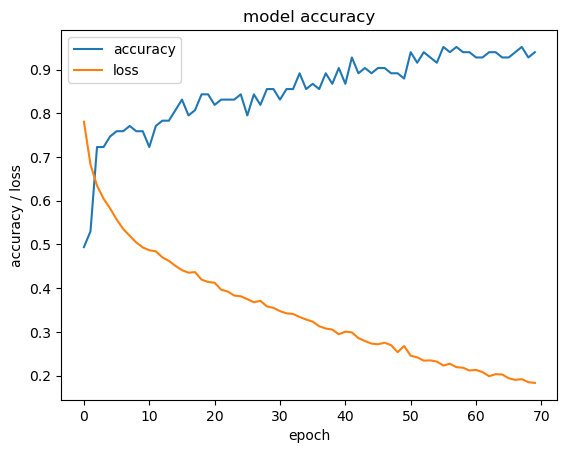

In [151]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.legend(["accuracy", "loss"])
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.show()

In [152]:
model.evaluate(xTest, yTest)

1/1 [==============================] - 0s 342ms/step - loss: 0.7314 - accuracy: 0.7143 - precision: 0.6667 - recall: 0.8000 - true_positives: 8.0000 - true_negatives: 7.0000 - false_positives: 4.0000 - false_negatives: 2.0000


[0.7313817143440247,
 0.7142857313156128,
 0.6666666865348816,
 0.800000011920929,
 8.0,
 7.0,
 4.0,
 2.0]

In [143]:
from sklearn.model_selection import KFold

In [144]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [145]:
i=0
scores = []
for train_index, test_index in list(KFold(n_splits=3).split(X,Y)):
    i+=1
    print("Fold ", str(i))
    x_train,x_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=Y.iloc[train_index],Y.iloc[test_index]
   
    model=getModel()

    model.fit(x_train.astype(np.float32), y_train,epochs=300, batch_size=1, verbose=2)
    clear_output(wait=True)

    results = model.evaluate(x_test.astype(np.float32), y_test)

    scores.append(results)


2/2 [==============================] - 0s 6ms/step - loss: 1.0208 - accuracy: 0.7647 - precision: 0.7857 - recall: 0.6875 - true_positives: 11.0000 - true_negatives: 15.0000 - false_positives: 3.0000 - false_negatives: 5.0000


In [146]:
acc = [score[1] for score in scores]
print(sum(acc)/len(acc))

0.7882353067398071
